In [1]:
import h5py
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

from genomic_utils.variant import Variant

In [2]:
ENFORMER_PREDS_DIR = "/data/yosef3/scratch/ruchir/data/enformer_hg19_predictions"

In [3]:
def load_enformer_scores_for_chrom(
    chrom: str, variants: set[str], track_idx: int = 5110
) -> tuple[dict, dict]:
    sad_scores = {}
    sar_scores = {}
    h5_path = os.path.join(ENFORMER_PREDS_DIR, f"1000G.MAF_threshold=0.005.{chrom}.h5")

    with h5py.File(h5_path, "r") as f:
        chr_ = f["chr"][:].astype(str)
        pos = f["pos"][:].astype(int)
        ref = f["ref"][:].astype(str)
        alt = f["alt"][:].astype(str)
        sad = f["SAD"][:, track_idx]
        sar = f["SAR"][:, track_idx]

        for i in range(len(chr_)):
            v_original = str(Variant(chr_[i], pos[i], ref[i], alt[i]))
            v_flipped = str(Variant(chr_[i], pos[i], alt[i], ref[i]))
            if v_original in variants:
                sad_scores[v_original] = sad[i]
                sar_scores[v_original] = sar[i]
            elif v_flipped in variants:
                sad_scores[v_flipped] = -1.0 * sad[i]
                sar_scores[v_flipped] = -1.0 * sar[i]

    return sad_scores, sar_scores

In [16]:
scores_df = pd.read_csv("ism_scores/znf83.csv", index_col=0)
scores_df["SAR"] = np.log2(1 + scores_df["alt"]) - np.log2(1 + scores_df["ref"])
scores_df.head()

,ref_forward,ref_reverse,alt_forward,alt_reverse,ref,alt,ISM_forward,ISM_reverse,ISM,SAR
chr19:53169321 G/A,0.597061,0.774816,0.595835,0.774256,0.685939,0.685046,-0.001226,-0.000560,-0.000893,-0.000764
chr19:53169330 T/C,0.555750,0.747766,0.549484,0.747240,0.651758,0.648362,-0.006266,-0.000526,-0.003396,-0.002969
chr19:53169342 G/A,0.502186,0.746477,0.501934,0.745259,0.624332,0.623597,-0.000252,-0.001218,-0.000735,-0.000653
chr19:53169348 C/T,0.513228,0.812837,0.512545,0.813251,0.663033,0.662898,-0.000684,0.000414,-0.000135,-0.000117
chr19:53169353 C/G,0.565738,0.783082,0.566984,0.781883,0.674410,0.674433,0.001246,-0.001199,0.000023,0.000020


In [37]:
enformer_sad_scores, enformer_sar_scores = load_enformer_scores_for_chrom(
    "19", set(scores_df.index)
)
scores_df["Enformer_SAD"] = scores_df.index.map(enformer_sad_scores)
scores_df["Enformer_SAR"] = scores_df.index.map(enformer_sar_scores)

In [8]:
def spearmanr_nan(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return spearmanr(a[mask], b[mask])


def pearsonr_nan(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return pearsonr(a[mask], b[mask])


def sign_agreemment_nan(a, b):
    mask = ~np.isnan(a) & ~np.isnan(b)
    return np.mean(np.sign(a[mask]) == np.sign(b[mask]))

In [33]:
def compare_scores(
    scores_df: pd.DataFrame,
    xcol: str,
    ycol: str,
    xlabel: str,
    ylabel: str,
):
    spearman = spearmanr_nan(scores_df[xcol], scores_df[ycol])[0]
    pearson = pearsonr_nan(scores_df[xcol], scores_df[ycol])[0]
    sign_agrmt = sign_agreemment_nan(scores_df[xcol], scores_df[ycol])

    fig, ax = plt.subplots()
    sns.scatterplot(data=scores_df, x=xcol, y=ycol, ax=ax)
    ax.axhline(0, color="black", linestyle="--", alpha=0.2)
    ax.axvline(0, color="black", linestyle="--", alpha=0.2)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.set_title(
        f"Spearman: {spearman:.2f}, Pearson: {pearson:.2f}, sign Agreement: {sign_agrmt:.2f}"
    )

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, "r-", alpha=0.5, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    plt.show()

# How similar are ISM_forward and ISM_reverse that we computed?

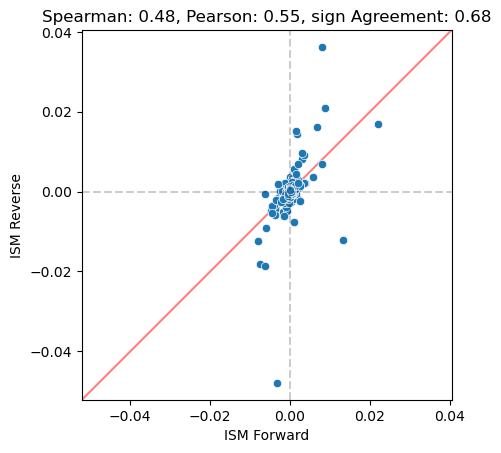

In [34]:
compare_scores(scores_df, "ISM_forward", "ISM_reverse", "ISM Forward", "ISM Reverse")

# How are similar are ISMs that we computed to those published by Enformer?

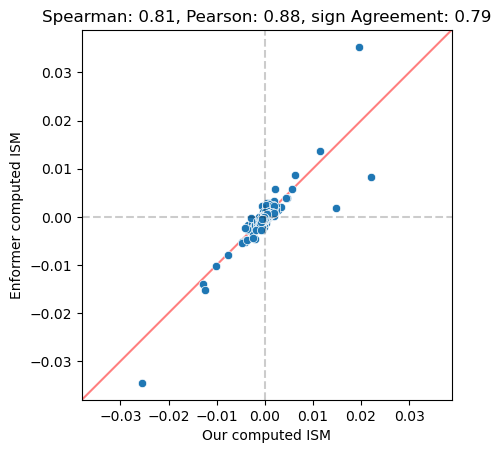

In [38]:
compare_scores(
    scores_df, "ISM", "Enformer_SAD", "Our computed ISM", "Enformer computed ISM"
)

# How similar are SARs that we computed to those published by Enformer?

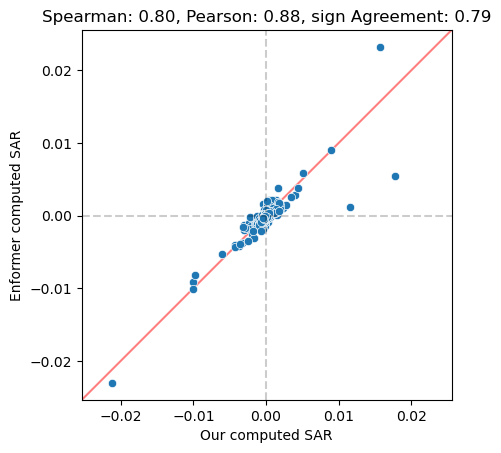

In [39]:
compare_scores(
    scores_df, "SAR", "Enformer_SAR", "Our computed SAR", "Enformer computed SAR"
)